In [6]:
import lorentz
import uproot
import uproot_methods.classes.TLorentzVector as LVepm
import numpy as np
import mplhep as hep
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import cauchy
from scipy.stats import expon
import pandas as pd

In [7]:
#this can take a few minutes for large files
eventsData = uproot.open("https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/2lep/Data/data_D.2lep.root")["mini"]
#eventsData.show()

In [8]:
nEvents = 100000 
#this is the total number of collisions/events we want to access from the file, you can reduce this
#for quick test, for final results 100000 events should be enough

lep_E, lep_pt, lep_phi, lep_eta, lep_type_Data = eventsData.arrays(["lep_E", "lep_pt", "lep_phi", "lep_eta", "lep_type"], outputtype=tuple, entrystop=nEvents)
flatData = LVepm.TLorentzVectorArray.from_ptetaphi(lep_pt, lep_eta, lep_phi, lep_E)

(array([6685., 6554., 5887., 6085., 5578., 6565., 6082., 6702., 6348.,
        6642., 5781., 6181., 5941., 6395., 6277.]),
 array([-3.14      , -2.72133333, -2.30266667, -1.884     , -1.46533333,
        -1.04666667, -0.628     , -0.20933333,  0.20933333,  0.628     ,
         1.04666667,  1.46533333,  1.884     ,  2.30266667,  2.72133333,
         3.14      ]),
 <a list of 15 Patch objects>)

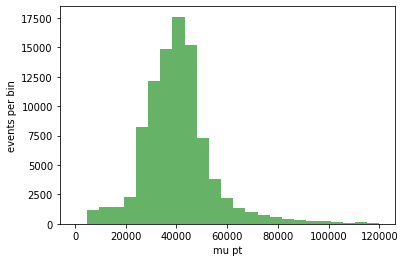

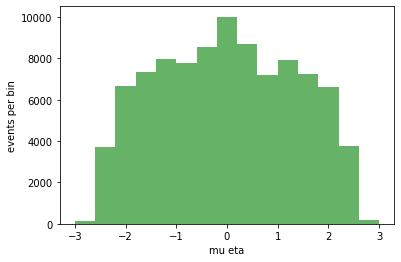

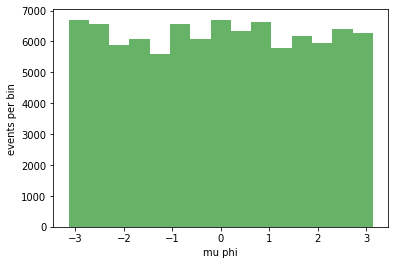

In [9]:
#create a few arrays to hold some specific information about the collisions
massesData = np.array([])
muPtData = np.array([])
muEtaData = np.array([])
muPhiData = np.array([])

nData = 0
nTarget = 100000
    
#loop over events and extract info from the array
for ev in range(0,len(flatData)):
    if ((lep_type_Data[ev][0] == 13) & (lep_type_Data[ev][1] == 13)) :
        mumu = flatData[ev][0] + flatData[ev][1] 
        mass = mumu.mass
        massesData = np.append(massesData,mass)
        muPtData = np.append(muPtData,flatData[ev][0].pt)
        muPtData = np.append(muPtData,flatData[ev][1].pt)
        muEtaData = np.append(muEtaData,flatData[ev][0].eta)
        muEtaData = np.append(muEtaData,flatData[ev][1].eta)
        muPhiData = np.append(muPhiData,flatData[ev][0].phi)
        muPhiData = np.append(muPhiData,flatData[ev][1].phi)
        nData = nData + 1
    if (nData == nTarget):
        break
        
# plot the mu pt histogram.
plt.figure()
plt.xlabel("mu pt")
plt.ylabel("events per bin")
plt.hist(muPtData, bins=25, range=[0,120000], alpha=0.6, color='g')

# plot the mu pseudorapdity histogram.
plt.figure()
plt.xlabel("mu eta")
plt.ylabel("events per bin")
plt.hist(muEtaData, bins=15, range=[-3.0,3.0], alpha=0.6, color='g')

# plot the mu phi histogram.
plt.figure()
plt.xlabel("mu phi")
plt.ylabel("events per bin")
plt.hist(muPhiData, bins=15, range=[-3.14,3.14], alpha=0.6, color='g')

32065600.0


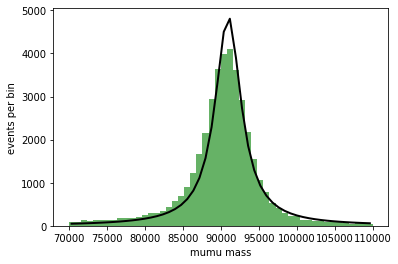

In [33]:
nBins =50 
minMass = 70000
maxMass = 110000

mZ  = 91000.0
sigmaZ = 2100


#redefine m(mumu) as a numpy histogram
countsData, edges = np.histogram(massesData, bins=nBins, range=(minMass, maxMass))
centres = (edges[1:] + edges[:-1]) / 2

# get the width of each bin
bin_width = edges[1] - edges[0]
# sum over number in each bin and mult by bin width, which can be factored out
integral = bin_width * sum(countsData[0:nBins])

print(integral)

#fit a Cauchy distributions to the dimuon mass histogram
#massesData = massesData[ (massesData >= 60000) & (massesData <= 120000) ]
mu, std = cauchy.fit(massesData)

x = np.linspace(minMass, maxMass, 50)

plt.figure()
p = (cauchy.pdf(x, mZ, sigmaZ) * integral)
plt.plot(centres, p, 'k', linewidth=2)
plt.hist(massesData, bins=nBins, range=[minMass, maxMass], alpha=0.6, color='g')
plt.xlabel("mumu mass")
plt.ylabel("events per bin")
plt.show()

#countsPDF = cauchy.pdf(centres, mZ, sigmaZ)
#chi2, ndf = calcChiSq(countsData, countsPDF)
#print("chi2 , ndf = " + str(chi2) + " " + str(ndf))

In [34]:
#chi-squared function
def calcChiSq(obs, preds):
    chiSq = 0.0
    ndf = len(obs)
    for bin in range(0, len(obs)):
        diff = preds[bin] - obs[bin]
        #print("diff = " + str(diff))
        var = np.abs(preds[bin])
        if (var != 0):
            chiSq += (diff**2)/(var)
            #print("obs, pred, diff, var  chi contrib = "+  str( obs[bin]) +" " +  str(preds[bin]) +" "+  str(diff) +" "+  str(var) +" " + str((diff**2)/(var)))
    return chiSq, ndf

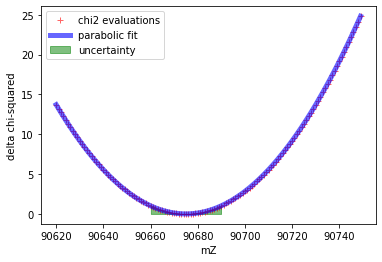

best-fit = 90675 +/- 14.847715426294599


In [35]:
mZAr = np.array([])
chi2Ar = np.array([])

minMz = 90620
maxMz = 90750
step = 1

bestFitMz1D = 0.0
minChi2 = 10000000

fig, ax = plt.subplots()

for mZ in range(minMz, maxMz, step):
    countsPDF = (cauchy.pdf(centres, mZ, sigmaZ) * integral)
    chi2, ndf = calcChiSq(countsData, countsPDF)
    mZAr = np.append(mZAr, mZ)
    chi2Ar = np.append(chi2Ar, chi2)
    if(chi2 < minChi2):
        minChi2 = chi2
        bestFitMz1D = mZ

chi2Ar = chi2Ar - np.min(chi2Ar)
    
ax.plot(mZAr, chi2Ar, 'r+', lw=5, alpha=0.6, label="chi2 evaluations")

z = np.polyfit(mZAr, chi2Ar, 2)
p = np.poly1d(z)

ax.plot(mZAr, p(mZAr), 'b-', lw=5, alpha=0.6, label="parabolic fit")

# 'statitical uncertianty' on our mZ measurement via critical values of chi-squared curve
y0 = 1.0
crit = (p - y0).roots

px=np.arange(crit[1],crit[0],0.001)

ax.fill_between(px,p(px),alpha=0.5, color='g', label="uncertainty")
ax.legend()

plt.xlabel("mZ")
plt.ylabel("delta chi-squared")
plt.show()

#What is causing the fluctuations around the expected parabolic shape?
#How could we smooth out this parabola?
#Why are the chi-quared values so small? Could our fit be that good? No.

#extract 1D result and uncertainty
my1DResult = bestFitMz1D
my1DUncertainty = bestFitMz1D-crit[1]
print("best-fit = " + str(my1DResult) + " +/- " + str(my1DUncertainty))

In [ ]:
#How about fitting the mass and the width at the same time?
minMz = 90450
maxMz = 90600

minSigmaZ = 3870
maxSigmaZ = 3970
step = 5

mZAr = np.arange(minMz, maxMz, step)
sigmaZAr = np.arange(minSigmaZ, maxSigmaZ, step)
chi2Ar = np.empty( (len(sigmaZAr), len(mZAr) ))

X, Y = np.meshgrid(mZAr, sigmaZAr)


bestFitMz2D = 0.0
minChi2 = 1000000

for yi in range(0, len(sigmaZAr)):
    for xi in range(0, len(mZAr)):
        #print( str(X[xi,yi]) + "," + str(Y[xi,yi]) )
        #print(chi2AtPoint(X[xi,yi],Y[xi,yi]))
        countsPDF = (cauchy.pdf(centres, X[yi, xi],Y[yi, xi]) * integral)
        chi2, ndf = calcChiSq(countsData, countsPDF)
        chi2Ar[yi, xi] = chi2
        if(chi2 < minChi2):
            #print("chi2 = " + str(chi2) + " mz = " + str(X[yi, xi]))
            minChi2 = chi2
            bestFitMz2D = X[yi, xi]

print(bestFitMz2D)
minChi2 = np.min(chi2Ar)
deltaChi2Ar = chi2Ar - minChi2

#plot 
levels = [2.3]
fig = plt.figure(figsize=(6,6))
ax = fig.gca()

cset = plt.contour(mZAr,sigmaZAr,deltaChi2Ar, levels=levels, colors=['white'])
cfset = plt.contourf(mZAr,sigmaZAr,deltaChi2Ar,  cmap='coolwarm')

h = plt.contourf(mZAr,sigmaZAr,deltaChi2Ar)

cbar = plt.colorbar(h)
cbar.set_label('Delta Chi-squared', rotation=270)
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('mZ')
ax.set_ylabel('sigmaZ')
plt.show()

#extract 2D result and uncertainty
my2DResult = bestFitMz2D
my2DUncertainty = bestFitMz2D-crit[1]
print("best-fit = " + str(my2DResult) + " +/- " + str(my2DUncertainty))

In [ ]:
#compare to PDG world average
mZPDG =  91187.6
sigmaZPDG = 2.1

mZPDGAr = np.array([mZPDG]) 
sigZPDGAr = np.array([sigmaZPDG]) 
yPDGAr = np.array([1.0]) 

mZ1D = np.array([my1DResult]) 
sigZ1D = np.array([my1DUncertainty]) 
y1D = np.array([2.0]) 

mZ2D = np.array([my2DResult]) 
sigZ2D = np.array([my2DUncertainty]) 
y2D = np.array([3.0]) 

plt.figure()

ax = plt.gca()
ax.set_xlim(90500, 91300)
ax.set_ylim(0.0, 4.0)

plt.errorbar(mZPDGAr, yPDGAr, xerr=sigZPDGAr, label="Particle Data Group", elinewidth=5,  fmt="o", mfc="blue", ms=8)
plt.errorbar(mZ1D, y1D, xerr=sigZ1D, fmt="o", label="ATLAS Open Data 1D", elinewidth=5, ms=8, mfc='blue')
plt.errorbar(mZ2D, y2D, xerr=sigZ2D, fmt="o", label="ATLAS Open Data 2D", elinewidth=5, ms=8, mfc='blue')

plt.legend()
plt.show()